In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy
import copy
import qiskit
import json
from qiskit.test.mock import FakeCasablanca
from mitiq import zne
import mitiq
from qiskit.providers.aer.extensions import SnapshotDensityMatrix
from mitiq.zne.scaling import fold_gates_from_left,fold_gates_at_random, fold_global,fold_gates_from_right
from mitiq.zne.inference import LinearFactory,RichardsonFactory,PolyFactory
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.providers.aer import AerSimulator
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit.opflow import I,X,Y,Z,StateFn,AbelianGrouper
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper,ParityMapper
from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit.quantum_info import Pauli
from qiskit.chemistry import FermionicOperator
from qiskit.aqua.operators.legacy import op_converter
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit import QuantumCircuit,execute,QuantumRegister,ClassicalRegister
from qiskit import Aer
from qiskit.circuit.random import random_circuit
from joblib import Parallel,delayed
from qiskit.aqua.operators import WeightedPauliOperator,Z2Symmetries
from qiskit.chemistry.components.variational_forms import UCCSD
import scipy

In [1]:
backend = FakeCasablanca() #Aer.get_backend('qasm_simulator')

NameError: name 'FakeCasablanca' is not defined

In [1]:
h_N=numpy.eye(8)
h_Sz=numpy.block([[numpy.eye(4),numpy.zeros((4,4))],
                  [numpy.zeros((4,4)),-1*numpy.eye(4)]])
def qubitOp(h1,h2):  
    fer_op=fermionic_op_builder.build_ferm_op_from_ints(h1,h2)
    qubit_conv = QubitConverter(ParityMapper(), two_qubit_reduction=True, z2symmetry_reduction="auto")
    qubit_op = qubit_conv.convert(fer_op, len(h1)//2)
    #mapper=JordanWignerMapper()
    #qubit_op=mapper.map(fer_op)
    return qubit_op 

NameError: name 'numpy' is not defined

In [ ]:
qubitN=qubitOp(h_N,numpy.zeros((8,8,8,8)))
N_matrix=qubitN.to_matrix()
qubitSz=qubitOp(h_Sz,numpy.zeros((8,8,8,8)))
Sz_matrix=qubitSz.to_matrix()

In [ ]:
def NumParticlesBitstring(bit_str):
    state_vector=numpy.zeros(2**6)
    state_vector[int(bit_str,2)]=1
    return numpy.real(state_vector@N_matrix@state_vector.T)
def SpinBitstring(bit_str):
    state_vector=numpy.zeros(2**6)
    state_vector[int(bit_str,2)]=1
    return numpy.real(state_vector@Sz_matrix@state_vector.T)

def filter_bitstrings(counts):
    Keys=list(counts.keys())
    Vals=list(counts.values())
    newCounts={}
    for i in range(len(Keys)):
        n=NumParticlesBitstring(Keys[i])
        s=SpinBitstring(Keys[i])
        if (numpy.abs(n-4)<1e-3 and  numpy.abs(s)<1e-3):
            newCounts[Keys[i]]=Vals[i]
        else:
            continue
    return newCounts        

In [ ]:
def confusion_matrix(num_qubits,noisy_backend,num_shots):
    num_qubits=6
    Dict_bitstr={}
    for i in range(2**num_qubits):
        qc=QuantumCircuit(num_qubits)
        bit_str=str(format(i,'b'))
        pos_Xs=numpy.where(numpy.array(list(bit_str)[::-1])=='1')[0]
        for ind in pos_Xs:
            qc.x(ind)
        qc=qiskit.transpile(qc,basis_gates=basis_gates,coupling_map=coupling_map)
        qc.add_register(ClassicalRegister(num_qubits,'c'))
        qc.measure([0,1,2,3,4,5],[0,1,2,3,4,5]) 
        job = noisy_backend.run(qc, shots=num_shots)
        #job = execute(qc, noisy_backend,shots=num_shots)#,basis_gates=basis_gates,noise_model=noise_model,had_transpiled=True) 
        res = job.result()
        counts = res.get_counts(qc)     
        Dict_bitstr[bit_str]=counts
    M=numpy.zeros((2**num_qubits,2**num_qubits))
    for i in range(2**num_qubits):
        transfer_map=Dict_bitstr[str(format(i,'b'))]
        Keys=list(transfer_map.keys())
        Values=list(transfer_map.values())
        for j in range(len(Keys)):
            print(i,int(Keys[j],2),Values[j]/num_shots)
            M[i][int(Keys[j],2)]=Values[j]/num_shots
    return M
def measurement_mitigate(M,counts):
    vec=numpy.zeros(M.shape[0])
    Keys=list(counts.keys())
    num_shots=sum(list(counts.values()))
    for i in range(len(Keys)):
        vec[int(Keys[i],2)]=counts[Keys[i]]/num_shots
        
    actual_vec=numpy.linalg.inv(M)@vec
    new_counts={}
    for i in range(len(Keys)):
        new_counts[Keys[i]]=actual_vec[int(Keys[i],2)]  
    return new_counts

In [ ]:
# numpy.set_printoptions(precision=3,suppress=True)
# noisy_backend=FakeCasablanca()
# M=confusion_matrix(6,noisy_backend,2**14)

In [2]:
#M.dump('confusion_matrix_IBMQ_Casablanca.npy')
M=numpy.load('confusion_matrix_IBMQ_Casablanca.npy',allow_pickle=True)

NameError: name 'numpy' is not defined

In [159]:
#load data
#load three Hamiltonian subparts
fileObject = open("H1.json", "r")
jsonContent = fileObject.read()
H_1 = json.loads(jsonContent)
fileObject = open("H2.json", "r")
jsonContent = fileObject.read()
H_2 = json.loads(jsonContent)
fileObject = open("H3.json", "r")
jsonContent = fileObject.read()
H_3 = json.loads(jsonContent)
H_1=PauliSumOp.from_list(H_1)
H_2=PauliSumOp.from_list(H_2)
H_3=PauliSumOp.from_list(H_3)
#load three different circuits with pre-rotation gates appended to the GS ansatz for measuring three parts
circ1=QuantumCircuit.from_qasm_file('qc1.txt')
circ2=QuantumCircuit.from_qasm_file('qc2.txt')
circ3=QuantumCircuit.from_qasm_file('qc3.txt')

In [331]:
state1=numpy.array(execute(circ1,Aer.get_backend('statevector_simulator')).result().get_statevector())
ideal_value1=numpy.real(numpy.conjugate(state1)@H_1.to_matrix()@state1)
state2=numpy.array(execute(circ2,Aer.get_backend('statevector_simulator')).result().get_statevector())
ideal_value2=numpy.real(numpy.conjugate(state2)@H_2.to_matrix()@state2)
state3=numpy.array(execute(circ3,Aer.get_backend('statevector_simulator')).result().get_statevector())
ideal_value3=numpy.real(numpy.conjugate(state3)@H_3.to_matrix()@state3)
E_exact=ideal_value1+ideal_value2+ideal_value3

In [160]:
fileObject = open("circuit1_counts.json", "r")
jsonContent = fileObject.read()
json_arr=jsonContent.split('\n')
counts1_arr=[eval(json_arr[i]) for i in range(len(json_arr)) if i%2==0]
fileObject = open("circuit2_counts.json", "r")
jsonContent = fileObject.read()
json_arr=jsonContent.split('\n')
counts2_arr=[eval(json_arr[i]) for i in range(len(json_arr)) if i%2==0]
fileObject = open("circuit3_counts.json", "r")
jsonContent = fileObject.read()
json_arr=jsonContent.split('\n')
counts3_arr=[eval(json_arr[i]) for i in range(len(json_arr)) if i%2==0]

In [161]:
def EnergyComponentFromSampling(counts_arr,Op):
    noisy_value_arr=[]
    for i in range(len(counts_arr)):
        counts=counts_arr[i]
        rho=numpy.zeros((2**6,2**6))
        Keys=list(counts.keys())
        Vals=list(counts.values())
        Num=len(Vals)
        tot=sum(Vals)
        for i in range(len(Keys)):
            rho[int(Keys[i],2)][int(Keys[i],2)]=Vals[i]/tot
        noisy_value=numpy.real(numpy.sum(numpy.diag(rho@Op.to_matrix())))
        noisy_value_arr.append(noisy_value)
    return noisy_value_arr

In [162]:
E1_1,E1_2,E1_3,E1_4=EnergyComponentFromSampling(counts1_arr,H_1)
E2_1,E2_2,E2_3,E2_4=EnergyComponentFromSampling(counts2_arr,H_2)
E3_1,E3_2,E3_3,E3_4=EnergyComponentFromSampling(counts3_arr,H_3)

In [228]:
E3_2,E3_3,E3_4

(-16.825754028192055, -15.832853772634126, -15.23056223725573)

In [163]:
E1_1,E1_2,E1_3,E1_4

(-0.3815750088014762,
 -0.37404081750976037,
 -0.17046689567910633,
 -0.10720967764517764)

In [164]:
from mitiq.zne.inference import RichardsonFactory,AdaExpFactory
# Initialize extrapolation method
scale_factors=[1.0,2.0,3.0]
def zne_Richardson_inference(scale_factors,noisy_expectation_values):
    fac = RichardsonFactory(scale_factors)
    # Load data into extrapolation factory
    for x, y in zip(scale_factors, noisy_expectation_values):
        fac.push({"scale_factor": x}, y)

    # Run extrapolation
    zero_noise = fac.reduce()
    return zero_noise,fac
def zne_adaexp_inference(steps,asymptote,noisy_expectation_values):
    fac = AdaExpFactory(steps=3, asymptote=0.001)
    # Load data into extrapolation factory
    for x, y in zip([1.   , 2.   , 2.634], noisy_expectation_values):
        fac.push({"scale_factor": x}, y)
    # Run extrapolation
    zero_noise = fac.reduce()
    return zero_noise,fac

In [257]:
zero_noise_estimate1,fac1=zne_adaexp_inference(3,0.001,[E1_2,E1_3,E1_4])
zero_noise_estimate2,fac2=zne_Richardson_inference([1,2,3],[E2_2,E2_3,E2_4])
zero_noise_estimate3,fac3=zne_Richardson_inference([1,2,3],[E3_2,E3_3,E3_4])
zero_noise_estimate1+zero_noise_estimate2+zero_noise_estimate3

-19.188214573682444

In [293]:
energyVals1=fac1.get_extrapolation_curve()
energyVals2=fac2.get_extrapolation_curve()
energyVals3=fac3.get_extrapolation_curve()
energy_vals=[energyVals1(scale_fac)+energyVals2(scale_fac)+energyVals3(scale_fac) for scale_fac in scale_factor_list]

In [291]:
scale_factor_list=numpy.linspace(0,3,15)

In [166]:
circ1_arr=[]
circ2_arr=[]
circ3_arr=[]
with open('circuit1.txt','r') as f:
    lines=f.readlines()
    Str=''
    for i in range(len(lines)):
        if lines[i][0]!='*':
            Str=Str+lines[i]
        elif lines[i][0]=='*':
            circ1_arr.append(Str)
            Str=''
with open('circuit2.txt','r') as f:
    lines=f.readlines()
    Str=''
    for i in range(len(lines)):
        if lines[i][0]!='*':
            Str=Str+lines[i]
        elif lines[i][0]=='*':
            circ2_arr.append(Str)
            Str=''
with open('circuit3.txt','r') as f:
    lines=f.readlines()
    Str=''
    for i in range(len(lines)):
        if lines[i][0]!='*':
            Str=Str+lines[i]
        elif lines[i][0]=='*':
            circ3_arr.append(Str)
            Str=''            

In [230]:
#The Hamiltonian is divided into three mutually commuting parts each can be rotated to a diagonal representation 
#by appending additional gates that correspond to single body rotations.
#function that measures first part of Hamiltonian
def executor(circuits_str, Op, shots=2**14,measure_mitiq=True,useSubspaceFilter=True):
    """Executes the input circuit and returns the noisy expectation value <A>, where A=|00>00|.
    """
    noisy_values=[]
    for circuit_str in circuits_str:
        circuit=QuantumCircuit.from_qasm_str(circuit_str)
        # Select a noisy backend
        # noisy_backend = qiskit.IBMQ.load_account().get_backend("ibmq_lima")
        noisy_backend = FakeCasablanca() # Simulator with noise model similar to "ibmq_lima"
        circuit_to_run = circuit.copy()
        #circuit_to_run=qiskit.transpile(circuit_to_run,backend=noisy_backend)
        print(f"Executing circuit with {len(circuit_to_run)} gates using {shots} shots.")
        # Compute expectation value of the observable Op
        job = noisy_backend.run(circuit_to_run, shots=shots)
        counts = job.result().get_counts()
        if (measure_mitiq==True):
            counts=measurement_mitigate(M,counts)
        if (useSubspaceFilter==True):
            counts=filter_bitstrings(counts)
        rho=numpy.zeros((2**6,2**6))
        Keys=list(counts.keys())
        Vals=list(counts.values())
        Num=len(Vals)
        tot=sum(Vals)
        for i in range(len(Keys)):
            rho[int(Keys[i],2)][int(Keys[i],2)]=Vals[i]/tot
        noisy_value=numpy.real(numpy.sum(numpy.diag(rho@Op.to_matrix())))
        noisy_values.append(noisy_value)
    return noisy_values

In [246]:
# e1_arr=[]
# e2_arr=[]
# e3_arr=[]
# zero_noise_e1_arr=[]
# zero_noise_e2_arr=[]
# zero_noise_e3_arr=[]
# for i in range(5):
#     e1_1,e1_2,e1_3,e1_4=executor(circ1_arr[:4], H_1, shots=2**14)
#     zero_noise_e1=zne_adaexp_inference(3,0.001,[e1_2,e1_3,e1_4])
#     e2_1,e2_2,e2_3,e2_4=executor(circ2_arr[:4], H_2, shots=2**14)
#     zero_noise_e2=zne_Richardson_inference([1,2,3],[e2_2,e2_3,e2_4])
#     e3_1,e3_2,e3_3,e3_4=executor(circ3_arr[:4], H_3, shots=2**14)
#     zero_noise_e3=zne_Richardson_inference([1,2,3],[e3_2,e3_3,e3_4])
#     zero_noise_e1_arr.append(zero_noise_e1[0])
#     zero_noise_e2_arr.append(zero_noise_e2[0])
#     zero_noise_e3_arr.append(zero_noise_e3[0])
#     e1_arr.append([e1_2,e1_3,e1_4])
#     e2_arr.append([e2_2,e2_3,e2_4])
#     e3_arr.append([e3_2,e3_3,e3_4])

In [242]:
error_zne=numpy.sqrt(numpy.var(zero_noise_e1_arr))+numpy.sqrt(numpy.var(zero_noise_e2_arr))+numpy.sqrt(numpy.var(zero_noise_e3_arr))

In [245]:
# with open('energy_noise_scaling_data.txt','w') as f:
#     print("circuit-1\n",file=f)
#     for i in range(len(e1_arr)):
#         print("run-%s "%(i+1)+','.join([str(e1_arr[i][j]) for j in range(3)]),file=f)
#     print("circuit-2\n",file=f)    
#     for i in range(len(e2_arr)):
#         print("run-%s "%(i+1)+','.join([str(e2_arr[i][j]) for j in range(3)]),file=f)
#     print("circuit-3\n",file=f)    
#     for i in range(len(e3_arr)):
#         print("run-%s "%(i+1)+','.join([str(e3_arr[i][j]) for j in range(3)]),file=f)
#     print("zero-noise-values-circuit-1\n",file=f) 
#     print(''.join(["run-%s "%(i+1)+str(zero_noise_e1_arr[i])+'\n' for i in range(5)]),file=f)
#     print("zero-noise-values-circuit-2\n",file=f) 
#     print(''.join(["run-%s "%(i+1)+str(zero_noise_e2_arr[i])+'\n' for i in range(5)]),file=f)
#     print("zero-noise-values-circuit-3\n",file=f) 
#     print(''.join(["run-%s "%(i+1)+str(zero_noise_e3_arr[i])+'\n' for i in range(5)]),file=f)

In [238]:
e1_arr=numpy.array(e1_arr)
e2_arr=numpy.array(e2_arr)
e3_arr=numpy.array(e3_arr)

In [239]:
err_e1_arr=numpy.sqrt(numpy.var(e1_arr,axis=0))
err_e2_arr=numpy.sqrt(numpy.var(e2_arr,axis=0))
err_e3_arr=numpy.sqrt(numpy.var(e3_arr,axis=0))

In [240]:
error_scaling_noise=err_e1_arr+err_e2_arr+err_e3_arr

In [244]:
error_scaling_noise,error_zne

(array([0.05123448, 0.06293332, 0.04504759]), 0.25474896837287)

In [247]:
import matplotlib.pyplot as plt

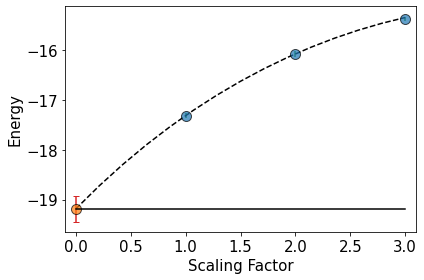

<Figure size 432x288 with 0 Axes>

In [351]:
fig,ax=plt.subplots(1)
ax.plot(scale_factor_list,energy_vals,linestyle='--',color='k',linewidth=1.5)
ax.plot([1,2,3],[E1_2+E2_2+E3_2,E1_3+E2_3+E3_3,E1_4+E2_4+E3_4],marker='o',markersize=10,markeredgecolor="black",alpha=0.7,linestyle='')
#zero noise value
ax.plot([0],zero_noise_estimate1+zero_noise_estimate2+zero_noise_estimate3,marker='o',markersize=10,markeredgecolor="black",alpha=0.7,linestyle='')
ax.errorbar([1,2,3],[E1_2+E2_2+E3_2,E1_3+E2_3+E3_3,E1_4+E2_4+E3_4], yerr=error_scaling_noise,linestyle='')
ax.errorbar([0],[zero_noise_estimate1+zero_noise_estimate2+zero_noise_estimate3], yerr=[error_zne],linestyle='',capsize=3)
ax.plot(scale_factor_list,E_exact*numpy.ones(len(scale_factor_list)),color='k')
ax.set_xlabel('Scaling Factor',fontsize=15)
ax.set_ylabel('Energy',fontsize=15)
ax.tick_params(labelsize=15)
ax.set_xlim([-0.1,3.1])
plt.tight_layout()
plt.show()
plt.savefig('gs_energy_determination_eg_model.png')